In [3]:
from radiomics import featureextractor
import os
from pathlib import Path
import pandas as pd
import logging


In [8]:

class TexturesError(Exception):
    """Base error related to Texture analysis method"""

def params_file_path(modality):
    main_path = Path('params_files')

    if modality == 'CT':
        params_path = main_path / 'params_CT.yaml'
    elif modality == 'MR':
        params_path = main_path / 'params_MR.yaml'
    else:
        raise TexturesError("Unsupported image modality!")
    
    return str(params_path)


# PARAMETERS #
###################################################
DISEASE = 'GIST' 
MODALITY = 'CT'

mask_file_name = 'mask.nii.gz'
serie_file_name = 'image.nii.gz'
###################################################


# List Patients
path_cases = '../data/' + DISEASE
patients = os.listdir(path_cases)
patients.sort()

if '.DS_Store' in patients:
    patients.remove('.DS_Store')

if '_output.log' in patients:
    patients.remove('_output.log')

if 'texture_results.csv' in patients:
    patients.remove('texture_results.csv')

for patient in patients:
    if not Path(path_cases + '/' + patient).is_dir():
        patients.remove(patient)

# Logger
path_log = path_cases + '/_output.log'
logging.basicConfig(filename=path_log, level=logging.INFO, filemode='w',
                    format='%(asctime)s - %(levelname)s - %(message)s')


df_radiomics = pd.DataFrame()

for p, patient in enumerate(patients):
    print(patient)
    logging.info(f'Analysing patient: {patient}')
    path_patient = Path(path_cases) / patient

    try:
        timepoints = os.listdir(path_patient)
        timepoints.sort()
    except NotADirectoryError:
        logging.error(f'Error in Directory {patient}')
        continue

    if '.DS_Store' in timepoints:
        timepoints.remove('.DS_Store')
    

    # Analyze Timepoints
    for t, timepoint in enumerate(timepoints):
        logging.info(f'Analysing timepoint: {timepoint} ')
        path_timepoint = path_patient / timepoint / 'NIFTI' 
        try: 
            path_mask = os.path.join(path_timepoint, mask_file_name)
            path_serie = os.path.join(path_timepoint, serie_file_name)

            if not os.path.exists(path_mask):
                logging.warning(f'Mask not detected for patient: {patient}, timepoint: {timepoint}')
                continue

            # TEXTURE ANALYSIS
            # ======================================
            params_path = params_file_path(MODALITY)
            extractor = featureextractor.RadiomicsFeatureExtractor(params_path)
            result = extractor.execute(path_serie, path_mask)

            # Store Results
            result = pd.DataFrame(result.items()).set_index(0).transpose()
            result.insert(0, 'PatientID', patient)
            df_radiomics = pd.concat([df_radiomics, result], axis=0)

        except Exception as e:
            logging.error(f'{patient} | {e}')
            continue



GIST-001_CT
GIST-002_CT
GIST-003_CT
GIST-004_CT
GIST-005_CT
GIST-006_CT
GIST-007_CT
GIST-008_CT
GIST-009_CT
GIST-010_CT
GIST-011_CT
GIST-012_CT
GIST-013_CT
GIST-014_CT
GIST-015_CT
GIST-016_CT
GIST-017_CT
GIST-018_CT
GIST-019_CT
GIST-020_CT
GIST-021_CT
GIST-022_CT
GIST-023_CT
GIST-024_CT
GIST-025_CT
GIST-026_CT
GIST-027_CT
GIST-028_CT
GIST-029_CT
GIST-030_CT
GIST-031_CT
GIST-032_CT
GIST-033_CT
GIST-034_CT
GIST-035_CT
GIST-036_CT
GIST-037_CT
GIST-038_CT
GIST-039_CT
GIST-040_CT
GIST-041_CT
GIST-042_CT
GIST-043_CT
GIST-044_CT
GIST-045_CT
GIST-046_CT
GIST-047_CT
GIST-048_CT
GIST-049_CT
GIST-050_CT
GIST-051_CT
GIST-052_CT
GIST-053_CT
GIST-054_CT
GIST-055_CT
GIST-056_CT
GIST-057_CT
GIST-058_CT
GIST-059_CT
GIST-060_CT
GIST-061_CT
GIST-062_CT
GIST-063_CT
GIST-064_CT
GIST-065_CT
GIST-066_CT
GIST-067_CT
GIST-068_CT
GIST-069_CT
GIST-070_CT
GIST-071_CT
GIST-072_CT
GIST-073_CT
GIST-074_CT
GIST-075_CT
GIST-076_CT
GIST-077_CT
GIST-078_CT
GIST-079_CT
GIST-080_CT
GIST-081_CT
GIST-082_CT
GIST-083_CT
GIST

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [9]:
# Save Radiomics
logging.info('Saving texture_results.csv')
path_results = path_cases + '/texture_results.csv'
df_radiomics.to_csv(path_results, index=False)


In [12]:
# Read clinical data and prepare to merge with radiomics results
clinical_df = pd.read_csv('../data/clinical_data.csv')
# Filter only GIST patients
clinical_df = clinical_df[clinical_df['Subject'].str.startswith('GIST')]
# Add suffix to Subject for CT modality to make it compatible with radiomics results
clinical_df['Subject'] = clinical_df['Subject'] + '_CT'

# Merge clinical data with radiomics results
df_all = df_radiomics.merge(clinical_df, left_on='PatientID', right_on='Subject', how='left')



In [14]:
# Save aggregated dataframe
logging.info('Saving texture_results_plus_clinical_data.csv')
path_results_clinical = path_cases + '/texture_results_plus_clinical_data.csv'
df_all.to_csv(path_results_clinical, index=False)


In [15]:
df_all.head()  # Display the first few rows of the aggregated dataframe

,PatientID,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,...,YOB,Notes,Age,Sex,Dataset,Diagnosis,Diagnosis_binary,Phenotype,MR Sessions,CT Sessions
0,GIST-001_CT,v3.0.1,1.24.4,2.5.0.dev,1.4.1,3.8.20,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},5c637760b10c85a50664384c6bffec559062fbae,3D,...,NaN,NaN,70,M,GIST,GIST,1,GIST,NaN,1.0
1,GIST-002_CT,v3.0.1,1.24.4,2.5.0.dev,1.4.1,3.8.20,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},b3318c749240991216db44d1623f03545ebcaf16,3D,...,NaN,NaN,77,M,GIST,non-GIST,0,Schwannoma,NaN,1.0
2,GIST-003_CT,v3.0.1,1.24.4,2.5.0.dev,1.4.1,3.8.20,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},1cfd3973cf84fe61456ec70b81bd5d54526d7f8f,3D,...,NaN,NaN,65,M,GIST,GIST,1,GIST,NaN,1.0
3,GIST-004_CT,v3.0.1,1.24.4,2.5.0.dev,1.4.1,3.8.20,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},2b733ee63c64529c3def603ca69bee2c784fc59f,3D,...,NaN,NaN,65,M,GIST,non-GIST,0,Schwannoma,NaN,1.0
4,GIST-005_CT,v3.0.1,1.24.4,2.5.0.dev,1.4.1,3.8.20,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},587739276b67478d100cae8edb9b8c301c992a08,3D,...,NaN,NaN,26,M,GIST,non-GIST,0,Lymphoma,NaN,1.0


# 3. Análisis descriptivo de variables clínicas y radiómicas


In [16]:
# Variables clínicas: distribución de edad, sexo y variables relevantes
clinical_vars = ['Age', 'Sex', 'Diagnosis', 'Diagnosis_binary', 'Phenotype']

# Estadísticas descriptivas para la edad
edad_desc = df_all['Age'].describe()
print('Distribución de Edad:')
print(edad_desc)

# Distribución de sexo
sexo_counts = df_all['Sex'].value_counts(dropna=False)
print('\nDistribución de Sexo:')
print(sexo_counts)

# Distribución de Diagnosis, Diagnosis_binary y Phenotype
for var in ['Diagnosis', 'Diagnosis_binary', 'Phenotype']:
    print(f"\nDistribución de {var}:")
    print(df_all[var].value_counts(dropna=False))

Distribución de Edad:
count    246.000000
mean      60.760163
std       13.608948
min       18.000000
25%       53.000000
50%       62.000000
75%       71.000000
max       91.000000
Name: Age, dtype: float64

Distribución de Sexo:
Sex
M    123
F    123
Name: count, dtype: int64

Distribución de Diagnosis:
Diagnosis
GIST        125
non-GIST    121
Name: count, dtype: int64

Distribución de Diagnosis_binary:
Diagnosis_binary
1    125
0    121
Name: count, dtype: int64

Distribución de Phenotype:
Phenotype
GIST                     125
Leiomyosarcoma            25
Gastricadenocarcinoma     25
Leiomyoma                 25
Schwannoma                23
Lymphoma                  23
Name: count, dtype: int64


Ahora se resumen estadísticamente las principales variables radiómicas extraídas (media, mediana, desviación estándar, mínimo y máximo). Se excluyen las columnas clínicas y de diagnóstico.

In [19]:
# Mostrar nombres y tipos de columnas candidatas a radiómicas
exclude_cols = ['PatientID', 'Age', 'Sex', 'Diagnosis', 'Diagnosis_binary', 'Phenotype', 'Subject', 'Dataset', 'Notes', 'YOB', 'MR Sessions', 'CT Sessions']
exclude_cols += [col for col in df_all.columns if col.startswith('diagnostics_')]

radiomic_cols = [col for col in df_all.columns if col not in exclude_cols]

print('Columnas candidatas a radiómicas y su tipo:')
print(df_all[radiomic_cols].dtypes)

print('\nPrimeros valores de cada columna candidata:')
print(df_all[radiomic_cols].head())

Columnas candidatas a radiómicas y su tipo:
original_shape_Elongation                  object
original_shape_Flatness                    object
original_shape_LeastAxisLength             object
original_shape_MajorAxisLength             object
original_shape_Maximum2DDiameterColumn     object
                                           ...   
original_ngtdm_Complexity                  object
original_ngtdm_Contrast                    object
original_ngtdm_Strength                    object
M/F                                        object
Hand                                      float64
Length: 107, dtype: object

Primeros valores de cada columna candidata:
  original_shape_Elongation original_shape_Flatness  \
0                  0.929884                 0.69719   
1                  0.825941                 0.74357   
2                  0.793163                0.625783   
3                  0.590011                0.575368   
4                  0.968503                0.660457   

  o

### Análisis exploratorio de las variables radiómicas
A continuación se realiza un análisis exploratorio de las variables radiómicas numéricas extraídas, incluyendo:
- Estadísticos descriptivos (media, mediana, desviación estándar, mínimo, máximo)
- Histograma de la distribución de valores para las 5 features más variables
- Matriz de correlación entre las principales features

Estadísticos descriptivos de las variables radiómicas numéricas:


,mean,median,std,min,max
original_shape_VoxelVolume,408684.247967,91342.500000,933806.804408,708.000000,7.930040e+06
original_shape_MajorAxisLength,88.069417,71.062515,56.555991,12.445748,3.228724e+02
original_shape_MinorAxisLength,65.518168,54.559152,41.005765,10.674467,2.136898e+02
original_shape_LeastAxisLength,44.362745,36.196070,33.050236,2.976210,1.829793e+02
original_shape_Flatness,0.537450,0.595232,0.218527,0.055109,9.294379e-01
original_shape_Elongation,0.763715,0.790246,0.135910,0.269965,9.874094e-01
M/F,NaN,NaN,NaN,NaN,NaN
Hand,NaN,NaN,NaN,NaN,NaN


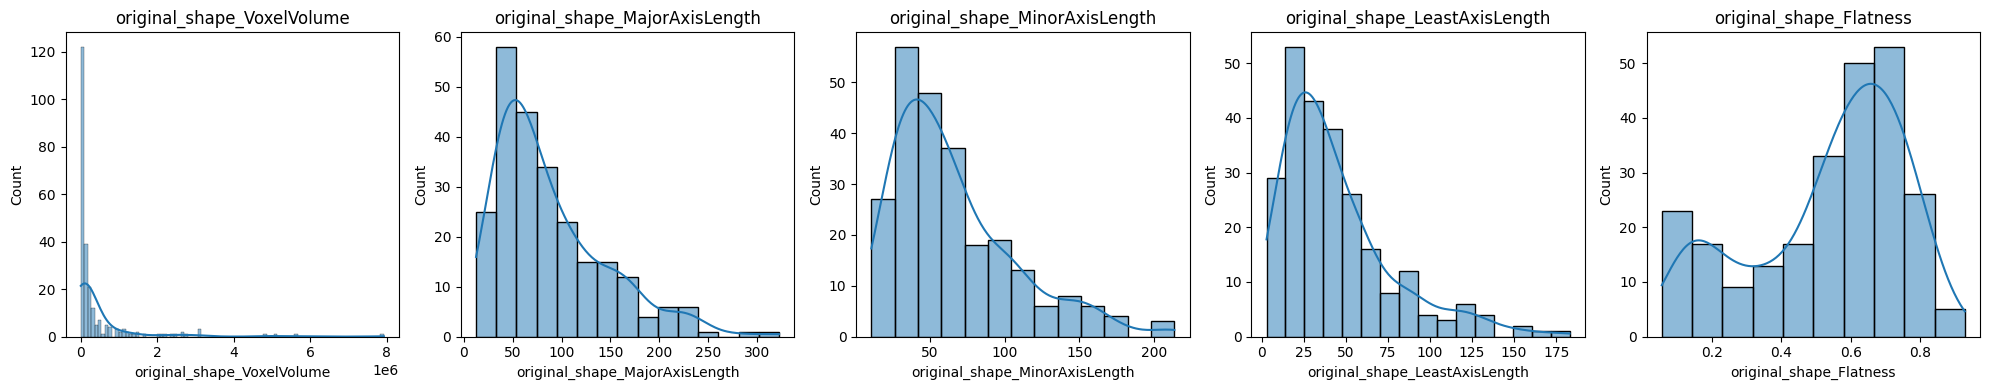

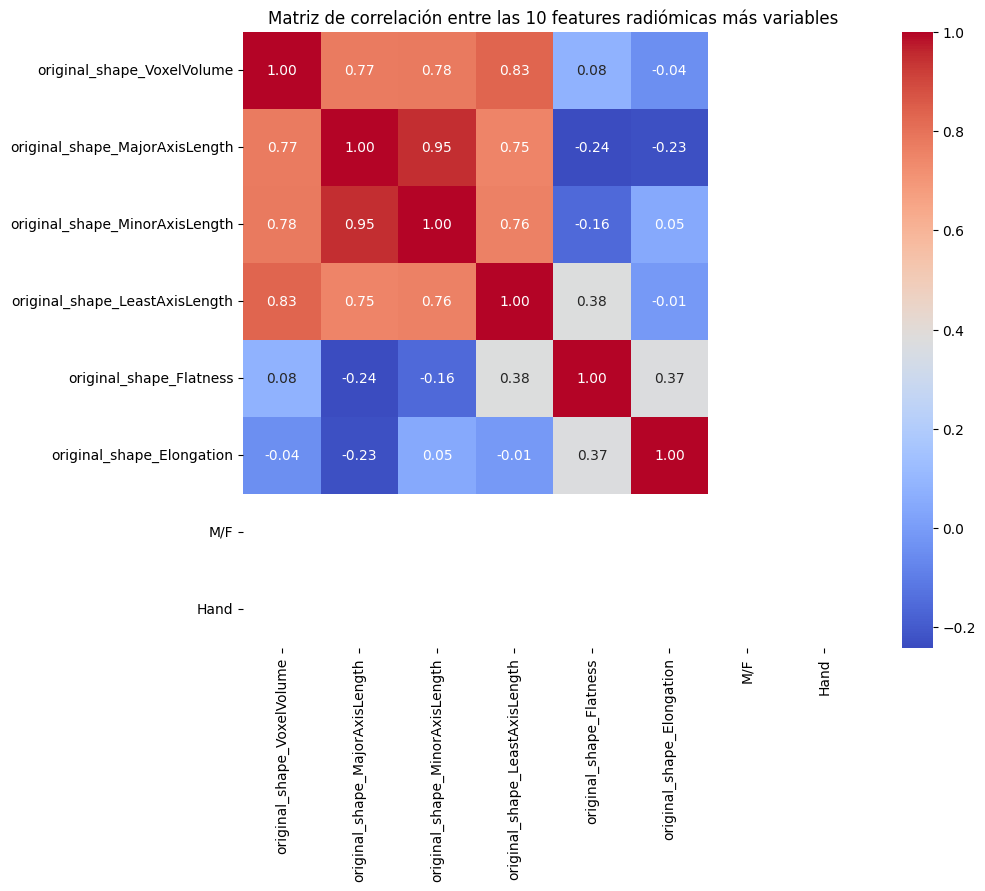

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selección de columnas radiómicas numéricas
exclude_cols = ['PatientID', 'Age', 'Sex', 'Diagnosis', 'Diagnosis_binary', 'Phenotype', 'Subject', 'Dataset', 'Notes', 'YOB', 'MR Sessions', 'CT Sessions']
exclude_cols += [col for col in df_all.columns if col.startswith('diagnostics_')]
radiomic_cols = [col for col in df_all.columns if col not in exclude_cols]
radiomic_numeric = df_all[radiomic_cols].apply(pd.to_numeric, errors='coerce')

# Estadísticos descriptivos
desc = radiomic_numeric.describe().T[['mean', '50%', 'std', 'min', 'max']].rename(columns={'50%': 'median'})
desc_sorted = desc.sort_values('std', ascending=False)
print('Estadísticos descriptivos de las variables radiómicas numéricas:')
display(desc_sorted)

# Seleccionar las 5 features más variables
top5 = desc_sorted.head(5).index.tolist()

# Histogramas
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(top5):
    sns.histplot(radiomic_numeric[col].dropna(), ax=axs[i], kde=True)
    axs[i].set_title(col)
plt.tight_layout()
plt.show()

# Matriz de correlación de las 10 features más variables
top10 = desc_sorted.head(10).index.tolist()
plt.figure(figsize=(10, 8))
sns.heatmap(radiomic_numeric[top10].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación entre las 10 features radiómicas más variables')
plt.show()

Este análisis permite identificar la variabilidad, distribución y relaciones entre las principales variables radiómicas extraídas del dataset.

### Distribución de las clases
A continuación se analiza la variable objetivo (Diagnosis_binary), mostrando el número y porcentaje de casos por clase, y visualizando la distribución con gráficos de barras y pastel.

Este análisis muestra la distribución de la variable objetivo, tanto en número absoluto como en porcentaje, vemos que las dos clases estan bastante balanceadas aqui. 

### Relación entre Diagnosis y Diagnosis_binary
A continuación se muestra una tabla cruzada y visualización conjunta de las variables Diagnosis y Diagnosis_binary para analizar la correspondencia entre ambas.

Tabla cruzada Diagnosis vs Diagnosis_binary:


Diagnosis_binary,0,1,All
Diagnosis,,,
GIST,0,125,125
non-GIST,121,0,121
All,121,125,246


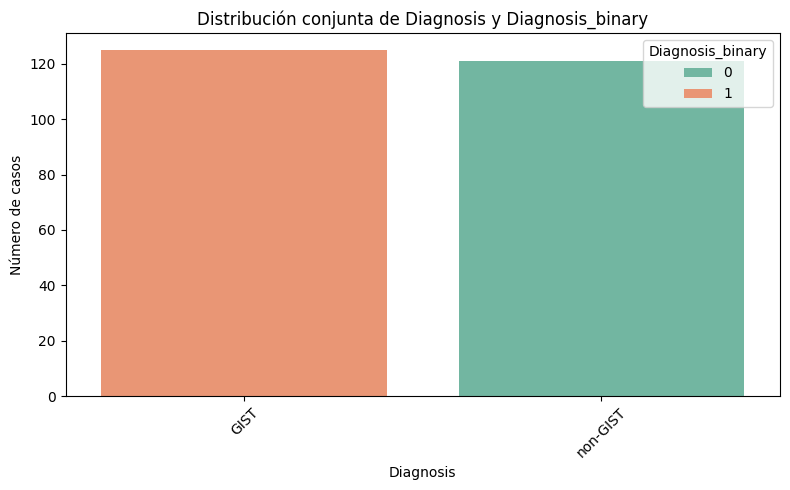

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tabla cruzada
cross_tab = pd.crosstab(df_all['Diagnosis'], df_all['Diagnosis_binary'], margins=True)
print('Tabla cruzada Diagnosis vs Diagnosis_binary:')
display(cross_tab)

# Gráfico de barras agrupadas
plt.figure(figsize=(8,5))
sns.countplot(data=df_all, x='Diagnosis', hue='Diagnosis_binary', palette='Set2')
plt.title('Distribución conjunta de Diagnosis y Diagnosis_binary')
plt.xlabel('Diagnosis')
plt.ylabel('Número de casos')
plt.legend(title='Diagnosis_binary')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

A partir de la tabla cruzada entre Diagnosis y Diagnosis_binary, se pueden extraer las siguientes conclusiones:

**Correspondencia perfecta entre variables:**
- Todos los casos con Diagnosis = "GIST" tienen Diagnosis_binary = 1 (125 casos).
- Todos los casos con Diagnosis = "non-GIST" tienen Diagnosis_binary = 0 (121 casos).
- No hay casos con Diagnosis = "GIST" y Diagnosis_binary = 0, ni con Diagnosis = "non-GIST" y Diagnosis_binary = 1.

**No hay discrepancias:**
- No existen inconsistencias entre ambas variables. Diagnosis_binary es una codificación binaria directa de Diagnosis.

**Distribución de clases:**
- Hay 125 casos de GIST (50.8%) y 121 casos de non-GIST (49.2%), lo que indica un dataset balanceado entre ambas clases.

**Conclusión:**
Diagnosis_binary representa fielmente la variable Diagnosis, codificando "GIST" como 1 y "non-GIST" como 0. No hay errores de codificación ni casos ambiguos. El dataset es equilibrado, lo que es favorable para análisis estadísticos y modelos de clasificación.

# Correlación entre variables numéricas y la variable objetivo
Se calcula la correlación de Spearman entre las variables numéricas (radiómicas y clínicas) y Diagnosis_binary. Se muestran las 10 variables más correlacionadas positiva y negativamente.

# Asociación entre variables categóricas y la variable objetivo
Se analiza la asociación entre variables categóricas (clínicas) y Diagnosis_binary usando el test de chi-cuadrado. Se muestran los p-valores para identificar posibles asociaciones relevantes.

In [27]:
from scipy.stats import chi2_contingency

# Selección de variables categóricas (excluyendo Diagnosis, Diagnosis_binary, PatientID, Subject, Dataset, Notes, YOB)
cat_cols = ['Sex', 'Phenotype', 'MR Sessions', 'CT Sessions']

results = []
for col in cat_cols:
    contingency = pd.crosstab(df_all[col], df_all['Diagnosis_binary'])
    if contingency.shape[0] > 1 and contingency.shape[1] > 1:
        chi2, p, dof, expected = chi2_contingency(contingency)
        results.append({'Variable': col, 'p-value': p, 'chi2': chi2, 'dof': dof})

results_df = pd.DataFrame(results).sort_values('p-value')
print('Resultados del test de chi-cuadrado para variables categóricas:')
display(results_df)

Resultados del test de chi-cuadrado para variables categóricas:


,Variable,p-value,chi2,dof
1,Phenotype,3.965387e-51,246.000000,5
0,Sex,4.441565e-01,0.585521,1


In [35]:
# Buscar incidencias donde Phenotype es 'GIST' y Diagnosis_binary no es 1
incidencias = df_all[(df_all['Phenotype'] == 'GIST') & (df_all['Diagnosis_binary'] != 1)]
print(f"Número de incidencias: {len(incidencias)}")
display(incidencias[['PatientID', 'Phenotype', 'Diagnosis', 'Diagnosis_binary']])

Número de incidencias: 0


,PatientID,Phenotype,Diagnosis,Diagnosis_binary


La conclusión principal del análisis de asociación entre variables categóricas y la variable objetivo Diagnosis_binary es la siguiente:

- **Phenotype** muestra una asociación altamente significativa con Diagnosis_binary (p-value ≈ 3.97e-51, chi2 = 246). Pero despues he verificado que no tiene ninguna incidencia en el dataset donde el phenotype es GIST y el Diagnosis_binary no es 1 entonces esto representa la misma informacion probablemente.  

- **Sex** no muestra una asociación significativa con Diagnosis_binary (p-value ≈ 0.44, chi2 ≈ 0.59). Esto significa que la proporción de sexos es similar en ambos grupos y, por tanto, el sexo no es un factor discriminante entre GIST y non-GIST en este dataset.


# Análisis del fabricante de imagen
Si los metadatos contienen información sobre el fabricante o tipo de escáner, se analiza la posible existencia de sesgos o agrupaciones por fabricante. Se visualiza la distribución de clases y algunas características radiómicas por fabricante.

In [31]:
# Buscar columnas relacionadas con fabricante o escáner
display([col for col in df_all.columns if 'manufacturer' in col.lower() or 'scanner' in col.lower() or 'vendor' in col.lower()])

[]

In [33]:
# Si existe una columna relevante, por ejemplo 'Manufacturer', realiza el análisis
fabricante_col = None
for col in df_all.columns:
    if 'manufacturer' in col.lower() or 'scanner' in col.lower() or 'vendor' in col.lower():
        fabricante_col = col
        break

if fabricante_col:
    print(f"Columna de fabricante encontrada: {fabricante_col}")
    print(df_all[fabricante_col].value_counts(dropna=False))
    # Distribución de clases por fabricante
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(8,4))
    sns.countplot(data=df_all, x=fabricante_col, hue='Diagnosis_binary')
    plt.title('Distribución de Diagnosis_binary por fabricante')
    plt.xlabel('Fabricante')
    plt.ylabel('Número de casos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    # Distribución de una feature radiómica por fabricante
    feature = 'original_firstorder_Mean' if 'original_firstorder_Mean' in df_all.columns else None
    if feature:
        plt.figure(figsize=(8,4))
        sns.boxplot(data=df_all, x=fabricante_col, y=feature)
        plt.title(f'Distribución de {feature} por fabricante')
        plt.xlabel('Fabricante')
        plt.ylabel(feature)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
else:
    print('No se encontró información de fabricante o escáner en los metadatos.')

No se encontró información de fabricante o escáner en los metadatos.


No se dispone de información sobre el fabricante o tipo de escáner en los metadatos de este dataset, por lo que no es posible analizar posibles sesgos o agrupaciones por fabricante.

# 4. Contextualización clínica

Los tumores estromales gastrointestinales (GIST) son el tipo más común de tumor mesenquimal del tracto digestivo, originados principalmente en el estómago o el intestino delgado. Su diagnóstico diferencial frente a otros tumores mesenquimales (non-GIST) es fundamental, ya que el manejo clínico, el pronóstico y la respuesta al tratamiento pueden variar considerablemente entre ambos grupos.

En la práctica clínica, la distinción entre GIST y non-GIST suele basarse en hallazgos histopatológicos (biopsia) y estudios inmunohistoquímicos tras la obtención de una muestra tumoral. Sin embargo, existen situaciones en las que la obtención de tejido es limitada, la biopsia no es concluyente o los riesgos del procedimiento son elevados.

En este contexto, el desarrollo de modelos predictivos basados en biomarcadores radiómicos extraídos de imágenes de TC puede aportar valor añadido al diagnóstico no invasivo. La radiómica permite cuantificar características de textura, forma y heterogeneidad tumoral que pueden reflejar diferencias biológicas subyacentes entre GIST y otros tumores mesenquimales. Un modelo capaz de discriminar entre ambos grupos a partir de imágenes podría apoyar la toma de decisiones clínicas, orientar la necesidad de procedimientos invasivos y contribuir a una mejor planificación terapéutica.

En este trabajo, el objetivo es evaluar la capacidad de las variables radiómicas y clínicas para diferenciar entre GIST y non-GIST, proporcionando una herramienta de apoyo al diagnóstico basada en datos accesibles y no invasivos.

### Modelo predictivo: Regresión logística explicable

Se construirá un modelo de regresión logística utilizando las 10 variables radiómicas numéricas más correlacionadas con Diagnosis_binary, junto con las variables clínicas Age y Sex. Se realizará un split estratificado 70% train, 15% validación, 15% test. Se evaluará el modelo con F1-score y se mostrarán los coeficientes y p-values de las variables para valorar su significancia.

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
import statsmodels.api as sm

# 1. Selección de las 10 variables radiómicas más correlacionadas con Diagnosis_binary
radiomic_numeric = df_all[radiomic_cols].apply(pd.to_numeric, errors='coerce')
correlations = radiomic_numeric.corrwith(df_all['Diagnosis_binary'], method='spearman').abs()
top10_corr = correlations.sort_values(ascending=False).head(10).index.tolist()

# 2. Preparar el dataframe de entrada
features = top10_corr + ['Age', 'Sex']
X = df_all[features].copy()
X['Sex'] = X['Sex'].map({'M': 1, 'F': 0})
y = df_all['Diagnosis_binary']

# Eliminar filas con NaN en X o y
mask = X.notnull().all(axis=1) & y.notnull()
X = X[mask]
y = y[mask]

# 3. Split 70/15/15 estratificado
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# 4. Entrenamiento del modelo
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

# 5. Evaluación
for split, X_split, y_split in [('Train', X_train, y_train), ('Val', X_val, y_val), ('Test', X_test, y_test)]:
    y_pred = model.predict(X_split)
    f1 = f1_score(y_split, y_pred)
    print(f"{split} F1-score: {f1:.3f}")
    print(classification_report(y_split, y_pred, digits=3))

# 6. Coeficientes y p-values usando statsmodels
X_train_sm = sm.add_constant(X_train)
# Convert all columns to float to avoid dtype=object issues
X_train_sm = X_train_sm.astype(float)
y_train_sm = y_train.astype(float)
logit_model = sm.Logit(y_train_sm, X_train_sm)
result = logit_model.fit(disp=0)
summary_df = result.summary2().tables[1]
print("Coeficientes y p-values de las variables:")
display(summary_df)

# Mostrar solo las variables con p-value < 0.05
print("Variables con p-value < 0.05:")
display(summary_df[summary_df['P>|z|'] < 0.05])

Train: 172, Val: 37, Test: 37
Train F1-score: 0.683
              precision    recall  f1-score   support

           0      0.673     0.776     0.721        85
           1      0.743     0.632     0.683        87

    accuracy                          0.703       172
   macro avg      0.708     0.704     0.702       172
weighted avg      0.709     0.703     0.702       172

Val F1-score: 0.686
              precision    recall  f1-score   support

           0      0.667     0.778     0.718        18
           1      0.750     0.632     0.686        19

    accuracy                          0.703        37
   macro avg      0.708     0.705     0.702        37
weighted avg      0.709     0.703     0.701        37

Test F1-score: 0.722
              precision    recall  f1-score   support

           0      0.700     0.778     0.737        18
           1      0.765     0.684     0.722        19

    accuracy                          0.730        37
   macro avg      0.732     0.731  

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,0.794062,1.306028,0.607998,0.543189,-1.765706,3.353830
original_firstorder_Minimum,-0.002067,0.002916,-0.708706,0.478507,-0.007782,0.003649
original_glszm_SmallAreaHighGrayLevelEmphasis,-0.003886,0.006135,-0.633318,0.526526,-0.015911,0.008139
original_firstorder_10Percentile,-0.003930,0.003036,-1.294165,0.195608,-0.009881,0.002022
original_glszm_LowGrayLevelZoneEmphasis,-37.765727,17.204129,-2.195155,0.028152,-71.485200,-4.046254
original_gldm_SmallDependenceHighGrayLevelEmphasis,0.046814,0.064420,0.726690,0.467416,-0.079448,0.173075
original_glszm_HighGrayLevelZoneEmphasis,0.006180,0.007225,0.855304,0.392383,-0.007982,0.020342
original_glrlm_ShortRunHighGrayLevelEmphasis,-0.014603,0.011087,-1.317156,0.187786,-0.036332,0.007127
original_glrlm_HighGrayLevelRunEmphasis,0.039641,0.065778,0.602642,0.546747,-0.089282,0.168563
original_glszm_SmallAreaLowGrayLevelEmphasis,81.487032,33.377481,2.441378,0.014631,16.068371,146.905692


Variables con p-value < 0.05:


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
original_glszm_LowGrayLevelZoneEmphasis,-37.765727,17.204129,-2.195155,0.028152,-71.485200,-4.046254
original_glszm_SmallAreaLowGrayLevelEmphasis,81.487032,33.377481,2.441378,0.014631,16.068371,146.905692


**Notas:**
- Si alguna variable no es significativa (p-value > 0.05), se recomienda considerar su exclusión y volver a ajustar el modelo.
- El F1-score se reporta para train, validación y test.
- Los coeficientes y p-values permiten interpretar la importancia y significancia estadística de cada variable.

### Modelo final solo con variables significativas

Se reentrena el modelo de regresión logística únicamente con las dos variables radiómicas que resultaron significativas (p < 0.05):
- original_glszm_LowGrayLevelZoneEmphasis
- original_glszm_SmallAreaLowGrayLevelEmphasis

Se evalúa el F1-score y se muestran los nuevos coeficientes y p-values.

In [44]:
# Variables significativas
sig_vars = ['original_glszm_LowGrayLevelZoneEmphasis', 'original_glszm_SmallAreaLowGrayLevelEmphasis']

X_sig = df_all[sig_vars].copy()
mask = X_sig.notnull().all(axis=1) & y.notnull()
X_sig = X_sig[mask]
y_sig = y[mask]

# Split 70/15/15 estratificado
X_train, X_temp, y_train, y_temp = train_test_split(X_sig, y_sig, test_size=0.30, stratify=y_sig, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# Entrenamiento
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

# Evaluación
for split, X_split, y_split in [('Train', X_train, y_train), ('Val', X_val, y_val), ('Test', X_test, y_test)]:
    y_pred = model.predict(X_split)
    f1 = f1_score(y_split, y_pred)
    print(f"{split} F1-score: {f1:.3f}")
    print(classification_report(y_split, y_pred, digits=3))

# Coeficientes y p-values con statsmodels
X_train_sm = sm.add_constant(X_train).astype(float)
y_train_sm = y_train.astype(float)
logit_model = sm.Logit(y_train_sm, X_train_sm)
result = logit_model.fit(disp=0)
summary_df = result.summary2().tables[1]
print("Coeficientes y p-values de las variables (modelo reducido):")
display(summary_df)

Train: 172, Val: 37, Test: 37
Train F1-score: 0.650
              precision    recall  f1-score   support

           0      0.500     0.094     0.158        85
           1      0.506     0.908     0.650        87

    accuracy                          0.506       172
   macro avg      0.503     0.501     0.404       172
weighted avg      0.503     0.506     0.407       172

Val F1-score: 0.667
              precision    recall  f1-score   support

           0      0.500     0.056     0.100        18
           1      0.514     0.947     0.667        19

    accuracy                          0.514        37
   macro avg      0.507     0.501     0.383        37
weighted avg      0.507     0.514     0.391        37

Test F1-score: 0.679
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        18
           1      0.514     1.000     0.679        19

    accuracy                          0.514        37
   macro avg      0.257     0.500  

/Users/mauriciodeoliveirareis/.pyenv/versions/bioinformatics_py_3_8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mauriciodeoliveirareis/.pyenv/versions/bioinformatics_py_3_8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mauriciodeoliveirareis/.pyenv/versions/bioinformatics_py_3_8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,0.225967,0.199281,1.133912,0.256831,-0.164617,0.616551
original_glszm_LowGrayLevelZoneEmphasis,-43.739306,16.681977,-2.621950,0.008743,-76.435379,-11.043232
original_glszm_SmallAreaLowGrayLevelEmphasis,79.441847,32.380817,2.453361,0.014153,15.976612,142.907082


**Conclusión:**
- Este modelo es más simple y explicable, usando solo las variables estadísticamente significativas. Pero no es un modelo bueno porque no discrimina entre GIST y no GIST bien.


### Evaluación del modelo

Además del F1-score, se calcularán y mostrarán otras métricas de rendimiento del modelo en los conjuntos de train, validación y test:
- Accuracy
- AUC-ROC
- Matriz de confusión
- Curva ROC (solo para test)

Train F1-score: 0.650 | Accuracy: 0.506 | AUC-ROC: 0.676
              precision    recall  f1-score   support

           0      0.500     0.094     0.158        85
           1      0.506     0.908     0.650        87

    accuracy                          0.506       172
   macro avg      0.503     0.501     0.404       172
weighted avg      0.503     0.506     0.407       172



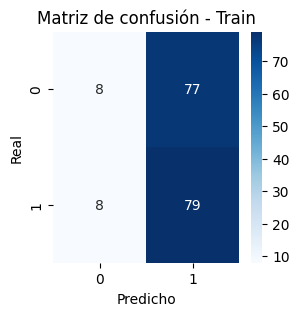

Val F1-score: 0.667 | Accuracy: 0.514 | AUC-ROC: 0.667
              precision    recall  f1-score   support

           0      0.500     0.056     0.100        18
           1      0.514     0.947     0.667        19

    accuracy                          0.514        37
   macro avg      0.507     0.501     0.383        37
weighted avg      0.507     0.514     0.391        37



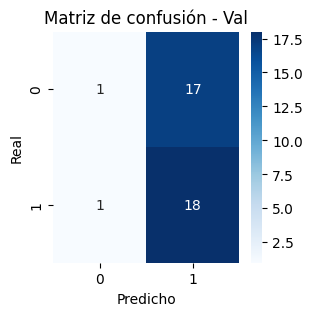

Test F1-score: 0.679 | Accuracy: 0.514 | AUC-ROC: 0.734
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        18
           1      0.514     1.000     0.679        19

    accuracy                          0.514        37
   macro avg      0.257     0.500     0.339        37
weighted avg      0.264     0.514     0.348        37



/Users/mauriciodeoliveirareis/.pyenv/versions/bioinformatics_py_3_8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mauriciodeoliveirareis/.pyenv/versions/bioinformatics_py_3_8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mauriciodeoliveirareis/.pyenv/versions/bioinformatics_py_3_8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

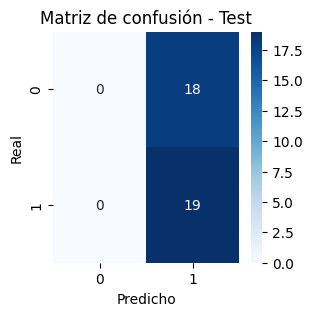

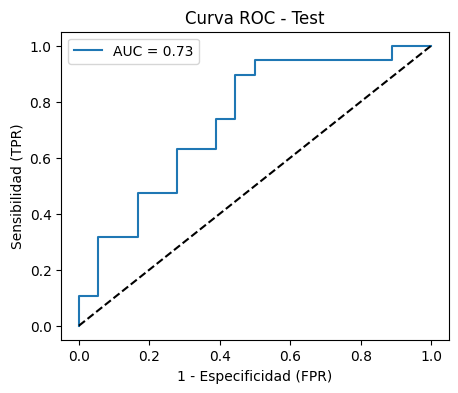

In [45]:
# Evaluación
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for split, X_split, y_split in [('Train', X_train, y_train), ('Val', X_val, y_val), ('Test', X_test, y_test)]:
    y_pred = model.predict(X_split)
    y_proba = model.predict_proba(X_split)[:, 1]
    f1 = f1_score(y_split, y_pred)
    acc = accuracy_score(y_split, y_pred)
    auc = roc_auc_score(y_split, y_proba)
    print(f"{split} F1-score: {f1:.3f} | Accuracy: {acc:.3f} | AUC-ROC: {auc:.3f}")
    print(classification_report(y_split, y_pred, digits=3))
    # Matriz de confusión
    cm = confusion_matrix(y_split, y_pred)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de confusión - {split}')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show()
    # Curva ROC solo para test
    if split == 'Test':
        fpr, tpr, _ = roc_curve(y_split, y_proba)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('1 - Especificidad (FPR)')
        plt.ylabel('Sensibilidad (TPR)')
        plt.title('Curva ROC - Test')
        plt.legend()
        plt.show()

# 6. Explicabilidad  

Las dos variables radiómicas seleccionadas para el modelo final, ambas derivadas de la matriz de zonas de nivel de gris (GLSZM), aportan información relevante sobre la textura y la heterogeneidad del tumor en las imágenes de TC:

- **original_glszm_LowGrayLevelZoneEmphasis (LGZE):**
  - Esta métrica cuantifica la proporción de zonas con valores bajos de gris en la imagen. Un valor alto indica que el tumor contiene muchas áreas homogéneas con baja intensidad, lo que puede estar relacionado con regiones menos densas o necróticas.
  - En el contexto de GIST, la presencia de zonas de baja atenuación puede reflejar necrosis, degeneración o menor celularidad, características que pueden diferenciar GIST de otros tumores mesenquimales.

- **original_glszm_SmallAreaLowGrayLevelEmphasis (SALGLE):**
  - Esta métrica mide la proporción de pequeñas áreas (zonas) con baja intensidad de gris. Un valor alto sugiere que existen múltiples focos pequeños y homogéneos de baja densidad dentro del tumor.
  - En GIST, la aparición de pequeñas áreas hipodensas puede estar asociada a patrones de crecimiento específicos, degeneración focal o cambios en la matriz extracelular, lo que puede ayudar a distinguirlos de otros tumores.

**Relevancia clínica:**
- Ambas variables reflejan la heterogeneidad interna y la composición tisular del tumor, aspectos que pueden estar relacionados con el subtipo molecular, la agresividad y la respuesta al tratamiento.
- Su capacidad para discriminar entre GIST y non-GIST de forma no invasiva puede ser útil para apoyar el diagnóstico y la toma de decisiones clínicas, especialmente cuando la biopsia no es concluyente o no es posible.

En resumen, estas variables radiómicas capturan patrones de textura que tienen correlato histopatológico y pondrian aportar valor añadido al diagnóstico por imagen de los tumores GIST pero el modelo corrente no es suficientemiente bueno para hacer esto. El AUC-ROC sugiere que, con un umbral diferente, pondria mejorar la sensibilidad para la clase 0, pero a costa de la clase 1. Lo mejor aqui iba a ser intentar crear otros modelos predictivos y/o utilizar tecnicas de feature selection como lasso.